## PS 5
## Donghai YU
## Feb. 18

## Q1

In [138]:
import pandas as pd 
from pandas import Series, DataFrame 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, confusion_matrix
from sklearn.model_selection import LeaveOneOut, KFold
import statsmodels.api as sm
from scipy.interpolate import LSQUnivariateSpline

In [139]:
data = pd.read_csv('strongdrink.txt')
data['const'] = 1
data.head()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline,const
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


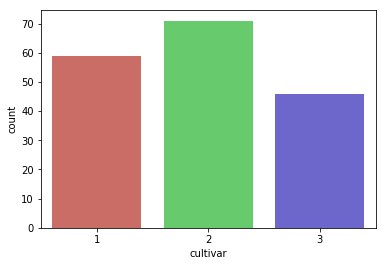

In [140]:
sns.countplot(x='cultivar', data=data, palette='hls')

In [141]:
X = data[['const', 'alco', 'malic', 'tot_phen', 'color_int']]
y = data['cultivar']

from sklearn.linear_model import LogisticRegression
X = data[['alco', 'malic', 'tot_phen', 'color_int']]
y = data['cultivar']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=20)
MultLogReg = LogisticRegression(multi_class='multinomial', solver='newton-cg')
MultLogReg.fit(X_train, y_train)
y_pred = MultLogReg.predict(X_test)
print(classification_report(y_test, y_pred))
print (f'The error rate for j=1 is {1-0.87} and the error rate for j=2 is 0.')
print(f'Validation set MSE = {mean_squared_error(y_test, y_pred)}')

             precision    recall  f1-score   support

          1       0.87      1.00      0.93        13
          2       1.00      0.90      0.95        21
          3       1.00      1.00      1.00        10

avg / total       0.96      0.95      0.96        44

The error rate for j=1 is 0.13 and the error rate for j=2 is 0.
Validation set MSE = 0.045454545454545456


In [142]:
print('Estimated intercept for j=1:', MultLogReg.intercept_[0])
print('Estimated coefficients for j=1:', MultLogReg.coef_[0])
print()
print('Estimated intercept for j=2:', MultLogReg.intercept_[1])
print('Estimated coefficients for j=2:', MultLogReg.coef_[1])

Estimated intercept for j=1: -24.0112737276
Estimated coefficients for j=1: [ 1.7004268  -0.26560789  1.22389489  0.02275117]

Estimated intercept for j=2: 22.8020733556
Estimated coefficients for j=2: [-1.46801536 -0.33305177  0.6640073  -0.92271031]


In [143]:
LR.intercept_

array([-24.0108148,  22.8025761,   1.2082387])

In [144]:
MSE_vs = ((y_test - y_pred) ** 2).sum() / y_pred.shape[0]
print('Validation set MSE = ', MSE_vs)

Validation set MSE =  0.045454545454545456



The error rate for $j=1$ is 0.03, for $j=2$ is 0, for $j=3$ is 0. It is best at predicting $j=3$. No, it has the least observations. Though $j=2$ is also very good and has the most.

b. Perform a leave-one-out cross validation (LOOCV) with the model from part (a). Report your error rates (1 - precision) for each category? How do your error rates compare to those from part (a)? Report your LOOCV estimate for the test MSE as the average MSE, where yi is the left out observation from each test set.

In [145]:
# b). leave-one-out cross validation 
from sklearn.model_selection import LeaveOneOut
N_loo = X.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(X)
MSE = pd.DataFrame({'index': np.zeros(N_loo), 
                    'error': np.zeros(N_loo), 
                    'y_pred': np.zeros(N_loo),
                    'y_test': np.zeros(N_loo)})

In [146]:
for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    MultLogReg1 = LogisticRegression(multi_class='multinomial', solver='newton-cg')
    MultLogReg1.fit(X_train, y_train)
    y_pred = MultLogReg1.predict(X_test)
    MSE['index'][test_index] = test_index
    MSE['error'][test_index] = 1 - (1 if y_test.values[0] == y_pred[0] else 0)
    MSE['y_pred'][test_index] = y_pred
    MSE['y_test'][test_index] = y_test

error_1 = MSE[MSE['y_pred'] == 1]['error'].mean()
error_2 = MSE[MSE['y_pred'] == 2]['error'].mean()
error_3 = MSE[MSE['y_pred'] == 3]['error'].mean()    
    
print(classification_report(MSE['y_test'], MSE['y_pred'], digits =3))
print('The error rate for class 1 is', error_1, ', std is', MSE[MSE['y_pred'] == 1]['error'].std())
print('The error rate for class 2 is', error_2, ', std is', MSE[MSE['y_pred'] == 2]['error'].std())
print('The error rate for class 3 is', error_3, ', std is', MSE[MSE['y_pred'] == 3]['error'].std())

MSE_loo = MSE['error'].mean()
MSE_loo_std = MSE['error'].std()
print('test estimate MSE loocv=', MSE_loo,
      ', test estimate MSE standard err=', MSE_loo_std)

             precision    recall  f1-score   support

        1.0      0.902     0.932     0.917        59
        2.0      0.914     0.901     0.908        71
        3.0      0.956     0.935     0.945        46

avg / total      0.921     0.920     0.921       176

The error rate for class 1 is 0.09836065573770492 , std is 0.3002730997379377
The error rate for class 2 is 0.08571428571428572 , std is 0.2819629507400967
The error rate for class 3 is 0.044444444444444446 , std is 0.20840907713999288
test estimate MSE loocv= 0.07954545454545454 , test estimate MSE standard err= 0.2713602101199873


In [147]:
# c). k-fold cross-validation
from sklearn.model_selection import KFold
k = 4
kf = KFold(n_splits=k, shuffle=True, random_state=10)
kf.get_n_splits(X)
MSE_vec_kf = np.zeros(k)
y_test_vec = np.array([])
y_pred_vec = np.array([])

k_ind = int(0)
for train_index, test_index in kf.split(X):
    # print("TRAIN:", train_index, "TEST:", test_index)
    print('k index=', k_ind)
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    y_test_vec = np.append(y_test_vec,y_test)    
    MultLogReg2 = LogisticRegression(multi_class='multinomial', solver='newton-cg')
    MultLogReg2.fit(X_train, y_train)
    y_pred = MultLogReg2.predict(X_test)
    y_pred_vec = np.append(y_pred_vec,y_pred)
    MSE_vec_kf[k_ind] = np.array([0 if y_test.values[i] == y_pred[i] else 1 for i in range(len(y_test))]).mean()
    print('MSE for test set', k_ind, ' is', MSE_vec_kf[k_ind])
    k_ind += 1

MSE_kf = MSE_vec_kf.mean()
MSE_kf_std = MSE_vec_kf.std()
print('test estimate MSE k-fold=', MSE_kf,
      'test estimate MSE standard err=', MSE_kf_std)

k index= 0
MSE for test set 0  is 0.159090909091
k index= 1
MSE for test set 1  is 0.113636363636
k index= 2
MSE for test set 2  is 0.0454545454545
k index= 3
MSE for test set 3  is 0.0454545454545
test estimate MSE k-fold= 0.0909090909091 test estimate MSE standard err= 0.04821182599


In [148]:
print(classification_report(y_test_vec, y_pred_vec))
print (f'the error rates for j=1,2,3 are 0.13, 0.09, 0.04 respectively.')

             precision    recall  f1-score   support

        1.0       0.87      0.93      0.90        59
        2.0       0.91      0.87      0.89        71
        3.0       0.96      0.93      0.95        46

avg / total       0.91      0.91      0.91       176

the error rates for j=1,2,3 are 0.13, 0.09, 0.04 respectively.



For $j=1$ the error rates are 0.29, 0, 0.06, 0.12. For $j=2$, the rates are 0, .31, 0.06, 0. For $j=3$ the rates are 0.22, 0, 0, 0. These are worse then in part 1. On average about the same as part (b).

### 2. Splines Interpolation

2(a)

In [149]:
data2 = pd.read_csv("Coolindex.txt", header=None)
data2.columns = ["age", "coolness_index"]
data2.head()

,age,coolness_index
0,11.0,10.981602
1,11.0,11.364925
2,11.0,10.190227
3,11.0,9.903725
4,11.0,8.997918


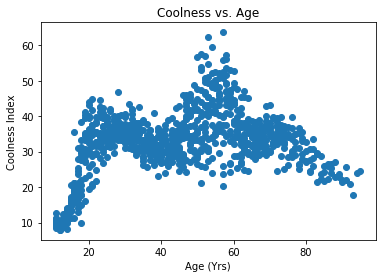

In [150]:
plt.scatter(x=cool.age, y=cool.coolness_index)
plt.xlabel("Age (Yrs)")
plt.ylabel("Coolness Index")
plt.title("Coolness vs. Age")
plt.show()

In [151]:
index = data2['coolness_index']
age = data2['age']
age_bin1 = (age < 22).astype(int)
age_bin2 = ((age >= 22) & (age < 40)).astype(int)
age_bin3 = ((age >= 40) & (age < 59)).astype(int)
age_bin4 = ((age >= 59) & (age < 77)).astype(int)
age_bin5 = ((age >= 77) & (age < 95)).astype(int)

In [152]:
X_step = pd.DataFrame(dict(age_bin1=age_bin1, age_bin2=age_bin2,
                           age_bin3=age_bin3, age_bin4=age_bin4,
                           age_bin5=age_bin5))

In [153]:
reg = sm.OLS(endog=index, exog=X_step, missing='drop')
reg_results = reg.fit()
print(reg_results.summary())

                            OLS Regression Results                            
Dep. Variable:         coolness_index   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     4280.
Date:                Mon, 19 Feb 2018   Prob (F-statistic):               0.00
Time:                        01:55:49   Log-Likelihood:                -3220.5
No. Observations:                 956   AIC:                             6451.
Df Residuals:                     951   BIC:                             6475.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age_bin1      20.1025      0.566     35.522      0.0

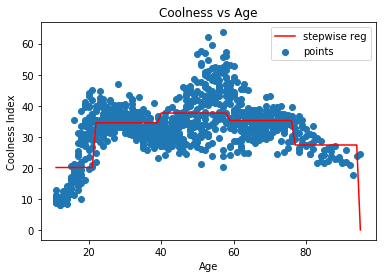

In [154]:
plt.scatter(age, index, label="points")
plt.plot(cool.age, reg_results.predict(X_step), color = 'r',label='stepwise reg')
plt.legend()
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.title('Coolness vs Age')
plt.show()

In [155]:
b1, b2, b3, b4, b5 = reg_results.params
print('beta_1 =', b1, ', beta_2 =', b2,
      ', beta_3 =', b3, ', beta_4 =', b4,
      ', beta_5 =', b5)
print('Thus, the predicted coolness for a 73-year old would be', reg_results.params[3])
reg_results.params

beta_1 = 20.1024572521 , beta_2 = 34.4757880776 , beta_3 = 37.6351054924 , beta_4 = 35.2254000402 , beta_5 = 27.3481669528
Thus, the predicted coolness for a 73-year old would be 35.2254000402


age_bin1    20.102457
age_bin2    34.475788
age_bin3    37.635105
age_bin4    35.225400
age_bin5    27.348167
dtype: float64

2(c)

In [156]:
knots = [22, 40, 59, 77]
spline_1 = LSQUnivariateSpline(age.values, index.values, knots, k=1)
pred_1 = spline_1(age)
pred_2 = spline_1(73)
print('Predicted Coolness of a 73-year old is', pred_2)

Predicted Coolness of a 73-year old is 32.536832389143306


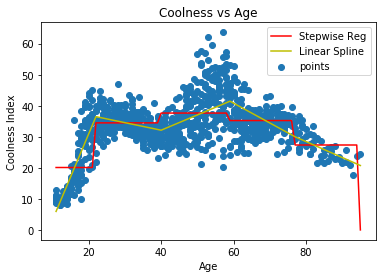

In [157]:
plt.scatter(age, index, label="points")
plt.plot(cool.age, reg_results.predict(X_step), color = 'r',label='Stepwise Reg')
plt.plot(cool.age, pred_1, color='y', label='Linear Spline')
plt.legend()
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.title('Coolness vs Age')
plt.show()

In [170]:
knots = [22, 40, 59, 77]
spline_2 = LSQUnivariateSpline(age.values, index.values, knots, k=3)
pred_3 = spline_2(73)
print('Predicted Coolness of a 73-year old is', pred_3)

Predicted Coolness of a 73-year old is 31.262429389257864


ValueError: x and y must have same first dimension, but have shapes (956,) and (1,)

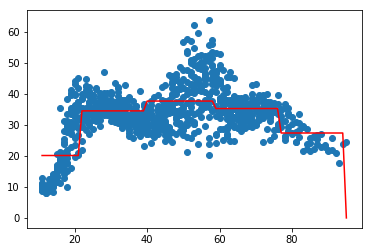

In [ ]:
predicted_age3 = spline(73)
print('Predicted Coolness of a 73-year old is', predicted_age3)